## Objectives:
1. Predict the rating that a user would give to a movie that he has not yet rated.
2. Minimize the difference between predicted and actual rating (RMSE and MAPE)
<br>

## Constraints:
1. Some form of interpretability. (Why we recommended that movie)
<br>

## Problem Mapping
* The given problem is a Recommendation problem 
* It can also seen as a Regression problem 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings   # to ignore the various warning poping up while block execution
warnings.filterwarnings('ignore')

import os
import re
import time
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

### Combining Data files

In [9]:
start = time.clock()

if not os.path.isfile('data_complete.csv'):
    
    data = open('data_complete.csv', mode='w')
    
    files = ['data/combined_data_1.txt', 'data/combined_data_2.txt', 'data/combined_data_3.txt', 'data/combined_data_4.txt' ]
    row = list()
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', time.clock() - start," secs")

Reading ratings from data/combined_data_1.txt...
Done.

Reading ratings from data/combined_data_2.txt...
Done.

Reading ratings from data/combined_data_3.txt...
Done.

Reading ratings from data/combined_data_4.txt...
Done.

Time taken : 544.1881466000013  secs


In [2]:
df = pd.read_csv('data_complete.csv',names = ['movie', 'user','rating','date'])
df.head()

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [3]:
# the Date time objects in the tex file are read as a string object rather a Date Time object
# Hence we need to tell python to take it as Time Object "  to_object() "

df.date = pd.to_datetime(df.date)
df.head()

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [4]:
df.date.dtype

dtype('<M8[ns]')

In [5]:
# Shorting dataframe by date

df.sort_values(by='date', inplace=True)
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [6]:
df.rating.value_counts()

4    33750958
3    28811247
5    23168232
2    10132080
1     4617990
Name: rating, dtype: int64

### Data Cleaning

In [11]:
df.columns

Index(['movie', 'user', 'rating', 'date'], dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 56431994 to 25464092
Data columns (total 4 columns):
movie     int64
user      int64
rating    int64
date      datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.7 GB


In [14]:
df.shape

(100480507, 4)

In [10]:
# Chcking nullvalue - 
no = sum(df.isnull().any(1))
print("NO of null values : ",no)

NO of null values :  0


In [12]:
# Checkig dulicate rows
dup = sum(df.duplicated(subset=['movie','user','rating','date']))
print("No of duplicate entries, including even timestamp : ",dup)

No of duplicate entries, including even timestamp :  0


In [15]:
# Checking duplicates without timestamp
dup = sum(df.duplicated(subset=['movie','user','rating']))
print("No of duplicate entries, excluding even timestamp : ",dup)

No of duplicate entries, excluding even timestamp :  0


In [27]:
print("No of unique Users = ",len(df.user.unique()))
print("No of unique Movies = ",len(df.movie.unique()))
print("No of unique Ratings = ",len(df.rating.unique()))

No of unique Users =  480189
No of unique Movies =  17770
No of unique Ratings =  5


## Splitting train and test data

* Not splitting data like regular train_test_splt()
* Since this is a time series data, we sort by time 
* use past data as train and latest data as test

In [29]:
df.shape[0]*0.80

80384405.60000001

In [30]:
# Saving train and test data in file
if not os.path.isfile('train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

In [12]:
train_df = pd.read_csv('train.csv', parse_dates = ['date'])
train_df.head()

,movie,user,rating,date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11
3,8651,510180,2,1999-11-11
4,14660,510180,2,1999-11-11


### ETA Test Data

In [8]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

[]

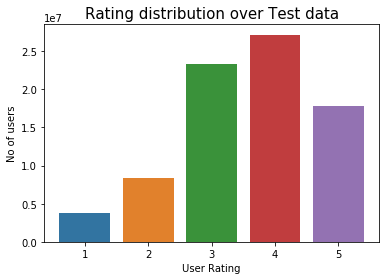

In [9]:
sns.countplot(x='rating', data=test_df)
plt.title("Rating distribution over Test data", fontsize=15 )
plt.xlabel("User Rating")
plt.ylabel("No of users")
# ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.plot()

In [11]:
no_rating_per_user = test_df.groupby(by='user')['rating'].count().sort_values(ascending=False)
no_rating_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

In [12]:
no_rating_per_user.tail()

user
804487     1
1999314    1
1847519    1
2562424    1
510123     1
Name: rating, dtype: int64

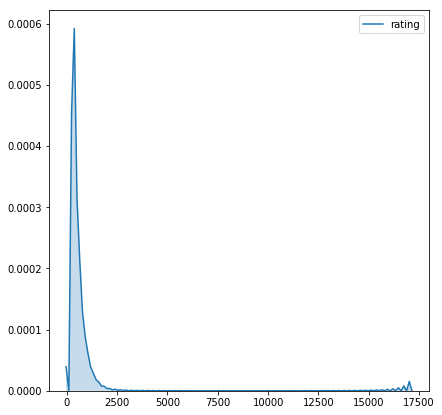

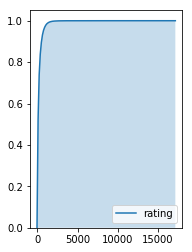

In [22]:
plt.figure(figsize=(15,7))

ax1 = plt.subplot(121)
sns.kdeplot(no_rating_per_user, shade=True, ax=ax1)

plt.show()


ax2 = plt.subplot(122)
sns.kdeplot(no_rating_per_user, ax=ax2, shade=True, cumulative=True)
plt.show()

In [3]:
# Adding day of week column to the data frame

train_df['day_of_week'] = train_df.date.dt.weekday_name

train_df.tail()

,movie,user,rating,date,day_of_week
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


In [8]:
# Checking the usefulness of features

no_rating_daily = train_df.groupby(by='day_of_week').count()

,movie,user,rating,date
day_of_week,,,,
Friday,10703108,10703108,10703108,10703108
Monday,13818790,13818790,13818790,13818790
Saturday,7963290,7963290,7963290,7963290
Sunday,8445834,8445834,8445834,8445834
Thursday,11634550,11634550,11634550,11634550
Tuesday,14221359,14221359,14221359,14221359
Wednesday,13597474,13597474,13597474,13597474


In [9]:
train_df.groupby(by='day_of_week')['rating'].count()

day_of_week
Friday       10703108
Monday       13818790
Saturday      7963290
Sunday        8445834
Thursday     11634550
Tuesday      14221359
Wednesday    13597474
Name: rating, dtype: int64

In [10]:
train_df.groupby(by='day_of_week')['rating'].mean()

day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64

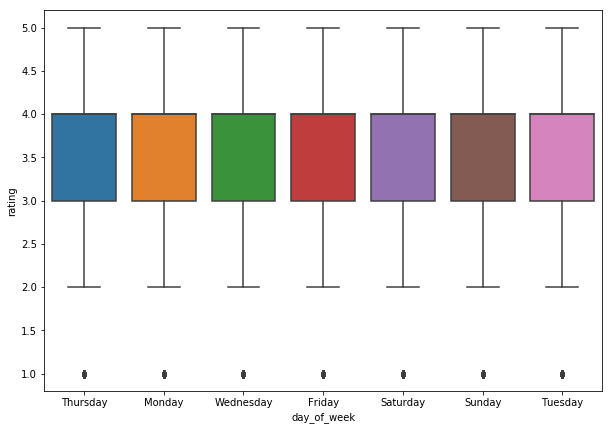

In [11]:
plt.figure(figsize=(10,7))
sns.boxplot(x = 'day_of_week' , y ='rating' , data=train_df)
plt.show()

In [5]:
# it seems all the rating have same means on all day of week
# day_of_week isn't helpful.

train_df = train_df.drop('day_of_week', axis=1 )
train_df.head()

,movie,user,rating,date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11
3,8651,510180,2,1999-11-11
4,14660,510180,2,1999-11-11


### Turnig theTrain dataframe into USRER-ITEM sparse matrxi

In [8]:
from scipy import sparse
from scipy.sparse import csr_matrix

In [16]:
train_df.shape

(80384405, 4)

In [19]:
print(train_df.movie.unique().shape)
train_df.user.unique().shape

(17424,)


(405041,)

In [13]:
if not os.path.isfile("train_sparse_matrix.npz")

    # csc_matrix ( data to fill in cells , ( row array, column array))
    train_sparse_matix = sparse.csc_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)))
    train_sparse_matix.shape
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matix)  # saving the train sparse matrix into NPZ file (numpy array format)
    
else:
    train_sparse_matix = sparse.load_npz("train_sparse_matrix.npz")
    train_sparse_matix.shape

(2649430, 17771)

In [20]:
print("No of non zeros elements in array : ",train_sparse_matix.count_nonzero())
print("No of elements in array : ",(train_sparse_matix.shape[0])*(train_sparse_matix.shape[1]))

No of non zeros elements in array :  80384405
No of elements in array :  47083020530


### Turnig theTest dataframe into USRER-ITEM sparse matrxi

In [15]:
test_df = pd.read_csv("test.csv")
print(test_df.shape)
test_df.head()

(20096102, 4)


,movie,user,rating,date
0,5926,2294429,2,2005-08-08
1,10158,1743373,4,2005-08-08
2,17064,381625,5,2005-08-08
3,1443,1252933,5,2005-08-08
4,1201,1434500,4,2005-08-08


In [22]:
if not os.path.isfile("test_sparse_matix.npz"):
    
    # csc_matrix ( data to fill in cells , ( row array, column array))
    test_sparse_matix = sparse.csc_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    test_sparse_matix.shape
    sparse.save_npz("test_sparse_matix.npz", test_sparse_matix)
    
else:
    test_sparse_matix = sparse.load_npz("test_sparse_matix.npz")
    test_sparse_matix.shape

In [35]:
test_sparse_matix.shape

(2649430, 17771)

In [36]:
test_sparse_matix.T.shape

(17771, 2649430)

### Cold Start Problem
<br>
New user are added daily in netflix, so how to recomment the mvies to them


In [22]:
# Cold start probelm with USER IDs

print("No of Unique user in train data : ",len(train_df.user.unique()))

print("No of Users that dont appear in  test data : ",(len(train_df.user.unique()) - len(test_df.user.unique())))

No of Unique user in train data :  405041
No of Users that dont appear in  test data :  55729


## Colaborative Recommendation System two way to implement
<br>
* Neighbourhood Technique
<br>
* Latent factor technique

## Colaborative Neighbourhood Techniques
<br>
Two ways to implement the Colaborative Neighbourhood technique--
<br>
1. Item-item similarity (movie-movie)
<br>
2. User-user similarity 



In [24]:
from sklearn.metrics.pairwise import cosine_similarity

### Movie - Movie Similairty

In [44]:
##  test_df --> sparse-matrix --> cosine-simlarity-matrix

In [24]:
train_sparse_matix.shape

(2649430, 17771)

In [27]:
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

It seems you don't have that file. Computing movie_movie similarity...
Done..
Saving it to disk without the need of re-computing it again.. 
Done..
It's a  (17771, 17771)  dimensional matrix


In [41]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [43]:
len(movie_ids)

17424

In [52]:
# Reading movie title file into dataframe

movie_titles = pd.read_csv("data/movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")
movie_titles.head()

Tokenization took: 3.99 ms
Type conversion took: 5.98 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [53]:
movie_titles.shape

(17770, 2)

#### Finding similar movies for given movie id

In [61]:
mv_id = 67

print("Name of movie : ",movie_titles.title[mv_id])

print("\nIt is rated by {} number of users.".format(np.count_nonzeront(train_sparse_matix[:,mv_id].toarray()))

print("\nWe have {} movies which are similar to this ".format(m_m_sim_sparse[:,mv_id].getnnz()))


Name of movie :  Vampire Journals

It is rated by 270 number of users.

We have 17284 movies which are similar to this 


#### Geting top similar movies and o/p TOP 10 similar movies-

In [131]:
no_top = 10

similarities = m_m_sim_sparse[mv_id].toarray().ravel() # numpy.ravel() is same as numpy.reshape(-1)

similar_indices = similarities.argsort()[::-1][1:] # bcz argshort by deafult sort by descending order [ : : -1]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:] # It will sort and reverse the array and ignore its similarity (ie.,1)
                                       # and return its indices(movie_ids)
movie_titles.loc[sim_indices[:no_top]]

,year_of_release,title
movie_id,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
13962,2001.0,Dracula: The Dark Prince
12053,1993.0,Dracula Rising
16279,2002.0,Vampires: Los Muertos
4667,1996.0,Vampirella
1900,1997.0,Club Vampire
13873,2001.0,The Breed


In [129]:
def similar_movie_find(movie_id , top_movie):
    
    print("Movie entered : ",movie_titles.title[movie_id])
    similar_mov_id      =  m_m_sim_sparse[:,movie_id].toarray().ravel()
    similar_mov_indices =  similar_mov_id.argsort()[::-1][1:]
    top_movies          =  similar_mov_indices[:top_movie]
    print("\nTop ",top_movie," recommended movies : \n")
    print(movie_titles.loc[top_movies])

In [130]:
similar_movie_find(67,10)

Movie entered :  Vampire Journals

Top  10  recommended movies : 

          year_of_release                     title
movie_id                                           
323                1999.0           Modern Vampires
4044               1998.0  Subspecies 4: Bloodstorm
1688               1993.0   To Sleep With a Vampire
13962              2001.0  Dracula: The Dark Prince
12053              1993.0            Dracula Rising
16279              2002.0     Vampires: Los Muertos
4667               1996.0                Vampirella
1900               1997.0              Club Vampire
13873              2001.0                 The Breed
15867              2003.0     Dracula II: Ascension


In [146]:
similar_movie_find(14659,10)

Movie entered :  Pokemon: Destiny Deoxys

Top  10  recommended movies : 

          year_of_release                                              title
movie_id                                                                    
14466              2004.0                        Pokemon: Jirachi Wish Maker
14453              2003.0                          Pokemon Heroes: The Movie
13164              2001.0                            Pokemon: Mewtwo Returns
9118               2004.0  Pokemon: Journey to the Johto League Champion:...
8423               2002.0                                      Pokemon 4Ever
12249              2001.0                               Pokemon 3: The Movie
3178               2003.0     Pokemon Master Quest: Collector's Box: Quest 2
16393              2000.0                            Pokemon: The Movie 2000
15127              2002.0     Pokemon Master Quest: Collector's Box: Quest 1
14754              1999.0                           Pokemon: The First Movie
